# Klasifikasi Citra Gambar 'Kertas Gunting Batu' dengan Tensorflow Keras

Hai, perkenalkan saya Rafka Imanda Putra, saya memiliki passion terhadap data science, dan saat ini saya masih duduk di bangku kelas 10 SMKN 4 Bandung jurusan Rekayasa Perangkat Lunak. 
 
Berikut ini adalah submission saya untuk lulus dengan baik di kelas Machine Learning untuk Pemula. Dalam pembuatannya, saya sangat terbantu dari berbagai referensi yang saya cantumkan dibagian paling bawah.

## Data Diri

Nama: Rafka Imanda Putra
 
Surel: rafka.0312@gmail.com
 
Dicoding username: rafka_imanda

## Persiapan Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
 
import zipfile, os
from google.colab import files
 
%matplotlib inline

## Menyiapkan Dataset dan Direktori

Mula-mula kita menyiapkan terlebih dahulu dataset yang akan digunakan untuk pemodelan. Kemudian dataset itu dibagi kedalam direktori yang telah ditentukan di /content/rockpaperscissors/(nama folder)

In [ ]:
!wget --no-check-certificate \
https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-05-04 06:45:32--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip.1’

rockpaperscissors.z 100%[===================>] 307.92M  1.09MB/s    in 5m 26s  

2021-05-04 06:50:58 (968 KB/s) - ‘rockpaperscissors.zip.1’ saved [322873683/322873683]



In [ ]:
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()
 
dir_gunting = os.path.join('/content/rockpaperscissors/scissors')
dir_batu = os.path.join('/content/rockpaperscissors/rock')
dir_kertas = os.path.join('/content/rockpaperscissors/paper')

In [ ]:
print('Jumlah data gunting: {}'.format(len(os.listdir('/content/rockpaperscissors/scissors'))))
print('Jumlah data batu: {}'.format(len(os.listdir('/content/rockpaperscissors/rock'))))
print('Jumlah data kertas: {}'.format(len(os.listdir('/content/rockpaperscissors/paper'))))

Jumlah data gunting: 750
Jumlah data batu: 726
Jumlah data kertas: 712


## Menerapkan Image Data Generator dan Men-split data validasi

Setelah dataset disiapkan, langkah selanjutnya adalah menggunakan ImageDataGenerator.
 
ImageDataGenerator ini tujuannya untuk mempersiapkan data latih dan data validasi agar siap dilakukan pemodelan.

Disini saya akan melakukan preprocessing data, pembagian data latih, pelabelan sampel otomatis, dan juga augmentasi gambar.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,      
    validation_split = 0.4,    
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True, 
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

In [ ]:
base_dir = '/content/rockpaperscissors/rps-cv-images/'
 
 
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
    )
 
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
    )

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## Membuat Arsitektur CNN

Setelah data siap dimodelkan, saya akan mendefinisikan arsitektur dari CNN-nya dengan 4 lapis layer konvolusi (Conv2D) dan max pooling (MaxPooling2D). Konvolusi berfungsi untuk mengekstrak atribut dari gambar, sedangkan max pooling berfungsi mereduksi resolusi gambar.
 
Saya juga telah mendefinisikan input layer, hidden layer, dan output layer dengan fungsi aktivasi masing-masing.
 
Dan tentunya, model yang dibuat akan dicompile agar model bisa belajar dengan sendirinya. Disini saya menspesifikasikan parameter optimizer 'Adam' dan loss function 'CategoricalEntropy'

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
 
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
model.compile(
    loss = CategoricalCrossentropy(), 
    optimizer = Adam(),
    metrics = ['accuracy']
)

## Menetapkan Callback

Penggunaan callback ini cukup penting sebelum model dilatih dengan fungsi fit. 
 
Disini, saya menspesifikasikan supaya pelatihan model berhenti bila mencapai akurasi 96% terlepas dari epoch ke berapa dia berada.

In [ ]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96):
      print('Lapor! Akurasi sudah melebihi 96%')
      self.model.stop_training = True

## Melatih Model

Setelah proses sebelumnya selesai, panggil fungsi fit dan spesifikasikan parameternya.
 
Setelah itu, model akan belajar sendiri dan kita tinggal menunggu hasilnya sampai dirasa memuaskan.

Disini saya menargetkan mendapatkan akurasi diatas 96% dengan waktu pelatihan dibawah 30 menit.
 
*Kembali ke proses sebelumnya sangat memungkinkan bila performa model kita buruk

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 150,
    validation_data = validation_generator,
    validation_steps = 4,
    verbose = 2,
    callbacks = [myCallback()]
)

Epoch 1/150
4/4 - 8s - loss: 1.1164 - accuracy: 0.3828 - val_loss: 1.0972 - val_accuracy: 0.3516
Epoch 2/150
4/4 - 6s - loss: 1.0893 - accuracy: 0.3594 - val_loss: 1.1339 - val_accuracy: 0.3125
Epoch 3/150
4/4 - 6s - loss: 1.0904 - accuracy: 0.4082 - val_loss: 1.0980 - val_accuracy: 0.3516
Epoch 4/150
4/4 - 7s - loss: 1.0918 - accuracy: 0.3047 - val_loss: 1.0930 - val_accuracy: 0.4141
Epoch 5/150
4/4 - 6s - loss: 1.0887 - accuracy: 0.3516 - val_loss: 1.0851 - val_accuracy: 0.4141
Epoch 6/150
4/4 - 7s - loss: 1.1085 - accuracy: 0.3125 - val_loss: 1.0884 - val_accuracy: 0.3203
Epoch 7/150
4/4 - 6s - loss: 1.0771 - accuracy: 0.5204 - val_loss: 1.0910 - val_accuracy: 0.3906
Epoch 8/150
4/4 - 6s - loss: 1.0805 - accuracy: 0.4297 - val_loss: 1.0875 - val_accuracy: 0.3516
Epoch 9/150
4/4 - 6s - loss: 1.0754 - accuracy: 0.4375 - val_loss: 1.0673 - val_accuracy: 0.4453
Epoch 10/150
4/4 - 6s - loss: 1.0793 - accuracy: 0.3469 - val_loss: 1.0671 - val_accuracy: 0.4141
Epoch 11/150
4/4 - 6s - loss:

## Membuat DataFrame Hasil Modelling

Disini saya ingin melihat hasil training dalam bentuk dataframe supaya memudahkan dilakukan eksplorasi seperti membuat plot.

In [ ]:
df = pd.DataFrame({'accuracy' : history.history['accuracy'],
                   'loss_accuracy': history.history['loss'],
                   'val_accuracy' : history.history['val_accuracy'],
                   'val_loss' : history.history['val_loss']
                   })
 
df.head()

,accuracy,loss_accuracy,val_accuracy,val_loss
0,0.382812,1.116368,0.351562,1.097244
1,0.359375,1.089324,0.312500,1.133933
2,0.408163,1.090379,0.351562,1.098017
3,0.304688,1.091818,0.414062,1.092971
4,0.351562,1.088702,0.414062,1.085051


In [ ]:
df.describe()

,accuracy,loss_accuracy,val_accuracy,val_loss
count,60.000000,60.000000,60.000000,60.000000
mean,0.731407,0.591002,0.737760,0.584223
std,0.187129,0.288466,0.197146,0.301915
min,0.304688,0.244802,0.312500,0.177101
25%,0.611328,0.386361,0.650391,0.340575
50%,0.820312,0.466411,0.824219,0.474671
75%,0.867188,0.855592,0.884766,0.837695
max,0.914062,1.116368,0.960938,1.133933


## Plotting Accuracy dan Val_accuracy

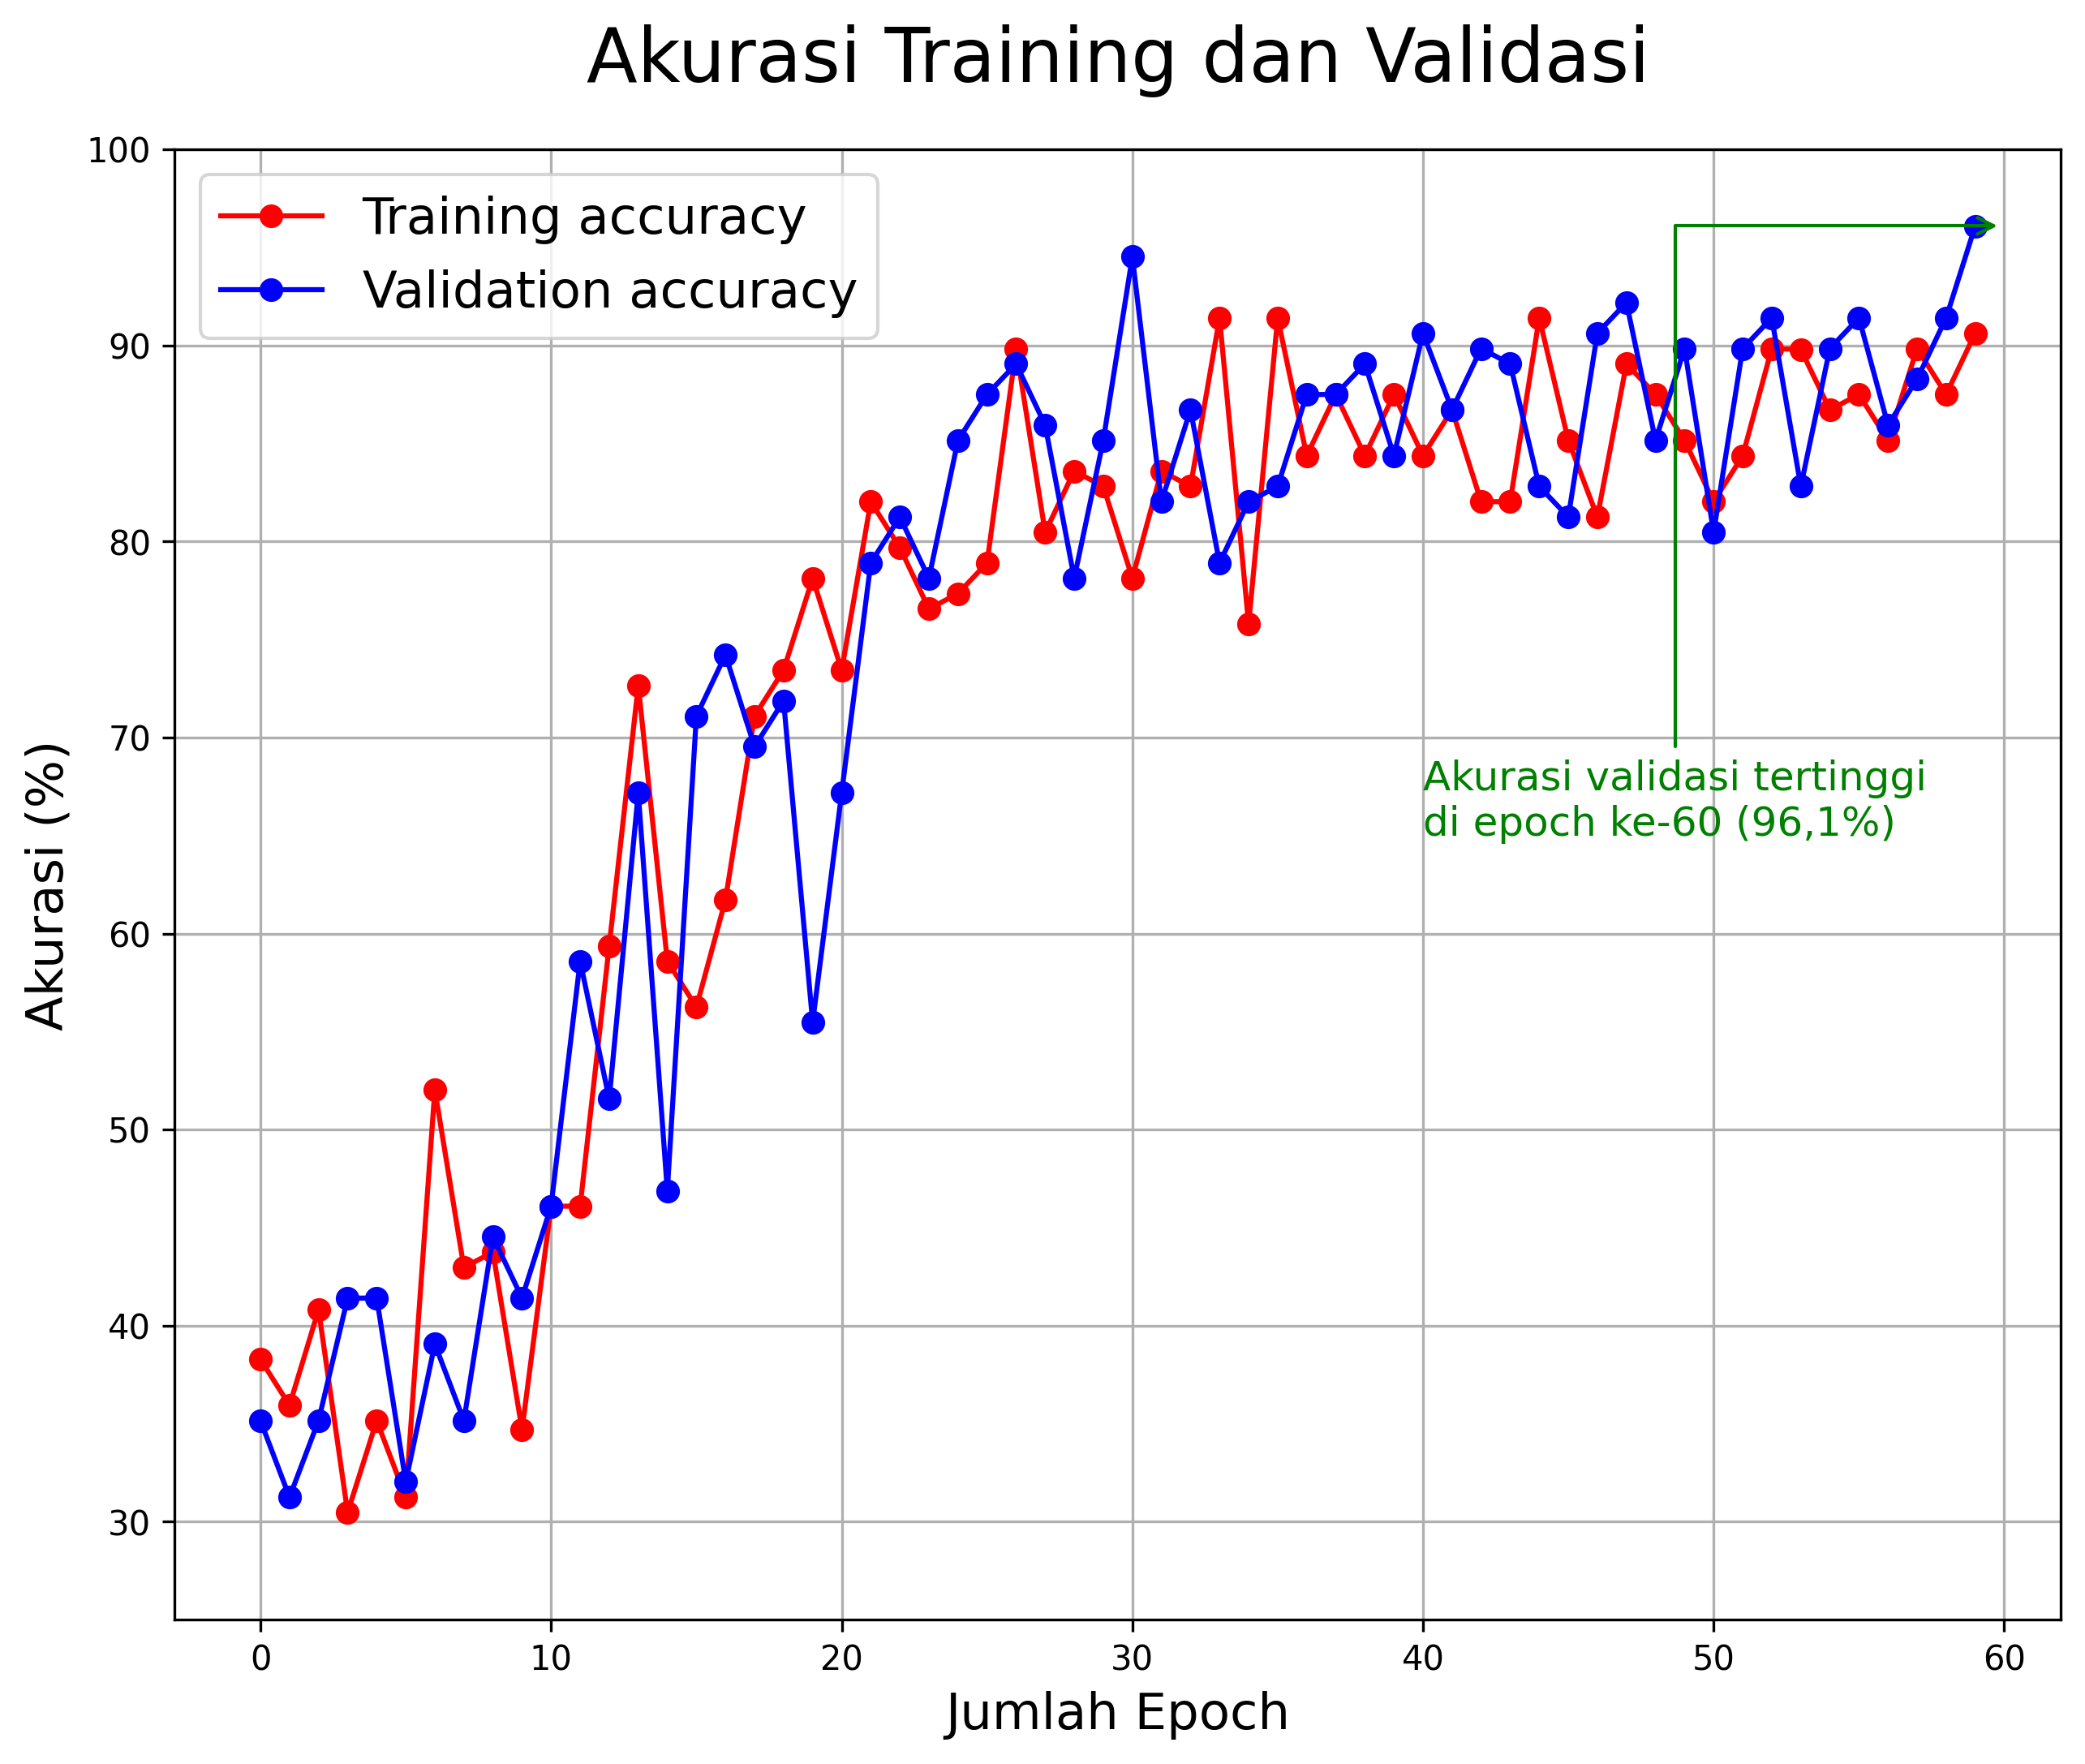

In [ ]:
acc = df['accuracy']
val_acc = df['val_accuracy']
 
fig, ax = plt.subplots(figsize=(10,8),dpi=300)
ax.plot(range(df.shape[0]), acc, color='r', marker='o', label='Training accuracy')
ax.plot( val_acc, color='b', marker='o',  label='Validation accuracy')
 
ax.set_title('Akurasi Training dan Validasi', fontsize=22, pad=20)
ax.set_xlabel('Jumlah Epoch', fontsize=15)
ax.set_ylabel('Akurasi (%)', fontsize=15)
 
plt.annotate('Akurasi validasi tertinggi\ndi epoch ke-60 (96,1%)',
                xy=(60,0.961), xytext=(40, 0.65), fontsize=12, color='green',
                arrowprops=dict(arrowstyle='->', connectionstyle='angle', color='green'))
ax.grid(True)
ax.legend(loc='best', fontsize=15)
labels, locations = plt.yticks()
plt.yticks(labels, (labels*100).astype(int))
plt.ylim(ymin=0.25, ymax=1)
 
plt.show()

## Memprediksi Gambar Baru

Untuk mengetahui performa model, saya akan mengetes dengan memberinya beberapa gambar yang seharusnya diprediksi sebagai kertas, gunting, batu, dan 'gambar salah' secara berturut-turut

In [ ]:
file = files.upload()

Saving 0Og76sl5CJhbxWWx.png to 0Og76sl5CJhbxWWx.png
Saving 0CSaM2vL2cWX6Cay.png to 0CSaM2vL2cWX6Cay.png
Saving 01dM3ewPIsnBICu1.png to 01dM3ewPIsnBICu1.png



0Og76sl5CJhbxWWx.png
[[1. 0. 0.]]
Hasil prediksi: Kertas

0CSaM2vL2cWX6Cay.png
[[0. 0. 1.]]
Hasil prediksi: Gunting

01dM3ewPIsnBICu1.png
[[0. 1. 0.]]
Hasil prediksi: Batu


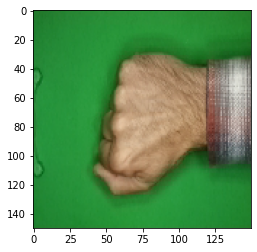

In [ ]:
for i in file.keys():
  path = i
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
 
  print('\n===========================================')
  print(i)
  print(classes)
  if classes[0][0] == 1:
    print('Hasil prediksi: Kertas')
  elif classes[0][1] == 1:
    print('Hasil prediksi: Batu')
  elif classes[0][2] == 1:
    print('Hasil prediksi: Gunting')
  else:
    print('Gambar salah')

Sekian dari saya, terimakasih atas ilmu yang telah diberikan, karena dengannya saya mulai sedikit memahami tentang machine learning yang dibutuhkan untuk menjadi seorang data scientist.
 
Mohon maaf bila ada kesalahan dari saya baik dari ucapan maupun code yang saya buat. 
 
Terimakasih Dicoding!
 
Salam hangat, Rafka Imanda Putra

## Referensi


https://www.dicoding.com/academies/184/tutorials/8527

https://www.tensorflow.org/api_docs/python/tf
 
https://www.megabagus.id/deep-learning-convolutional-neural-networks-aplikasi/2/
 
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback